In [1]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import acquire
from scipy import stats
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

np.random.seed(123)

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pasting a code I found from itertools documentation.

def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [3]:
zillow = acquire.get_zillow_data()

In [4]:
# Get a peek of the dataframe
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [5]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df

In [6]:
zillow = create_features(zillow)

In [7]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [8]:
b = handle_missing_values(zillow)

In [9]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77332 entries, 0 to 77573
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77332 non-null  int64  
 1   parcelid                      77332 non-null  int64  
 2   bathroomcnt                   77332 non-null  float64
 3   bedroomcnt                    77332 non-null  float64
 4   calculatedbathnbr             76915 non-null  float64
 5   calculatedfinishedsquarefeet  77330 non-null  float64
 6   finishedsquarefeet12          73878 non-null  float64
 7   fips                          77332 non-null  float64
 8   fullbathcnt                   76915 non-null  float64
 9   latitude                      77332 non-null  float64
 10  longitude                     77332 non-null  float64
 11  lotsizesquarefeet             69202 non-null  float64
 12  propertycountylandusecode     77332 non-null  object 
 13  p

In [10]:
# Remove observations where bedroom and bathroom counts are zero.
b = b[b.bedroomcnt != 0]
b = b[b.bathroomcnt !=0]

In [11]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76675 entries, 0 to 77573
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            76675 non-null  int64  
 1   parcelid                      76675 non-null  int64  
 2   bathroomcnt                   76675 non-null  float64
 3   bedroomcnt                    76675 non-null  float64
 4   calculatedbathnbr             76659 non-null  float64
 5   calculatedfinishedsquarefeet  76673 non-null  float64
 6   finishedsquarefeet12          73525 non-null  float64
 7   fips                          76675 non-null  float64
 8   fullbathcnt                   76659 non-null  float64
 9   latitude                      76675 non-null  float64
 10  longitude                     76675 non-null  float64
 11  lotsizesquarefeet             68561 non-null  float64
 12  propertycountylandusecode     76675 non-null  object 
 13  p

In [12]:
# Take a look at the amount of missing values.
b.isnull().sum()

id                                 0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                 16
calculatedfinishedsquarefeet       2
finishedsquarefeet12            3150
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet               8114
propertycountylandusecode          0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcity                    1425
regionidcounty                     0
regionidzip                       23
roomcnt                            0
yearbuilt                         57
structuretaxvaluedollarcnt        70
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          4
censustractandblock              191
logerror                           0
t

In [13]:
# Create a list of columns to drop.
columns_to_drop = ['calculatedbathnbr','finishedsquarefeet12','id','transactiondate','parcelid','fullbathcnt','propertycountylandusecode','propertylandusetypeid','rawcensustractandblock','regionidcounty','regionidzip','censustractandblock','propertylandusedesc']

In [14]:
# Create a function that will drop unwanted columns.
def drop_columns(df, drop_col):
    df = df.drop(columns=drop_col)
    return df

In [15]:
b = drop_columns(b, columns_to_drop)

In [16]:
b.isna().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       2
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8114
regionidcity                    1425
roomcnt                            0
yearbuilt                         57
structuretaxvaluedollarcnt        70
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          4
logerror                           0
age                               57
age_bin                           59
taxrate                            4
acres                           8114
acres_bin                       8114
sqft_bin                          12
structure_dollar_per_sqft         72
structure_dollar_sqft_bin         72
land_dollar_per_sqft            8114
lot_dollar_sqft_bin             8115
bath_bed_ratio                     0
c

### Drop more columns, that are captured in created features, before splitting.

In [ ]:
# Drop columns that are captured in other features.
b.drop(columns = ['bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 'fips', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt'], inplace=True)

In [ ]:
b.info()

### There are a few more columns with missing values that I will impute after I split.

In [17]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(b, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (42938, 28)
validate observations:  (18402, 28)
test observations:  (15335, 28)


In [18]:
train.isnull().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       1
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               4573
regionidcity                     816
roomcnt                            0
yearbuilt                         28
structuretaxvaluedollarcnt        43
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          2
logerror                           0
age                               28
age_bin                           30
taxrate                            2
acres                           4573
acres_bin                       4573
sqft_bin                           6
structure_dollar_per_sqft         44
structure_dollar_sqft_bin         44
land_dollar_per_sqft            4573
lot_dollar_sqft_bin             4573
bath_bed_ratio                     0
c

In [19]:
# I've decided to drop the null values instead of imputing. I will comment out the imputing lines of code.
train.dropna(inplace=True)
validate.dropna(inplace=True)
test.dropna(inplace=True)

In [20]:
train.info(), validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37538 entries, 29637 to 5668
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   37538 non-null  float64
 1   bedroomcnt                    37538 non-null  float64
 2   calculatedfinishedsquarefeet  37538 non-null  float64
 3   fips                          37538 non-null  float64
 4   latitude                      37538 non-null  float64
 5   longitude                     37538 non-null  float64
 6   lotsizesquarefeet             37538 non-null  float64
 7   regionidcity                  37538 non-null  float64
 8   roomcnt                       37538 non-null  float64
 9   yearbuilt                     37538 non-null  float64
 10  structuretaxvaluedollarcnt    37538 non-null  float64
 11  taxvaluedollarcnt             37538 non-null  float64
 12  assessmentyear                37538 non-null  float64
 13

(None, None)

In [ ]:
test.info()

In [ ]:
## use KNN imputer to fill missing values. 
#from sklearn.impute import KNNImputer
#
## Quantitative columns used for imputation.
#X_quant = train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'regionidcity', 'yearbuilt','structuretaxvaluedollarcnt', 'taxamount', 'age', 'landtaxvaluedollarcnt','']]
#
## Define the imputer.
#imputer = KNNImputer(n_neighbors=10)
#
## Fit the imputer on the train dataset. This method will transform it as well.
#train_imputed = imputer.fit_transform(X_quant)
#

In [ ]:
## Check if imputed column has any null values.
#pd.DataFrame(train_imputed).isnull().sum()

In [ ]:
## Convert imputed array to a dataframe
#train_imputed = pd.DataFrame(train_imputed, index = train.index)
#train_imputed.head()

In [ ]:
## Assign imputed values to the original columns.
#train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = train_imputed

In [ ]:
#train.head()

In [ ]:
## do the transformation on validate and test
#validate_imputed = imputer.transform(validate[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']])
#test_imputed = imputer.transform(test[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']])

In [ ]:
#validate.info()

In [ ]:
## convert arrays from above into dataframes
#validate_imputed = pd.DataFrame(validate_imputed, index = validate.index)
#test_imputed = pd.DataFrame(test_imputed, index = test.index)

In [ ]:
## assign imputed values to columns for validate and test dataframes
#validate[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = validate_imputed
#test[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = test_imputed

In [ ]:
## Check to make sure all dataframes have no missing values.
#validate.info(), test.info()

In [ ]:
## Remove remaining missing values.
#validate.dropna(inplace=True)
#test.dropna(inplace=True)

In [ ]:
## Check to make sure all dataframes have no missing values.
#validate.info(), test.info()

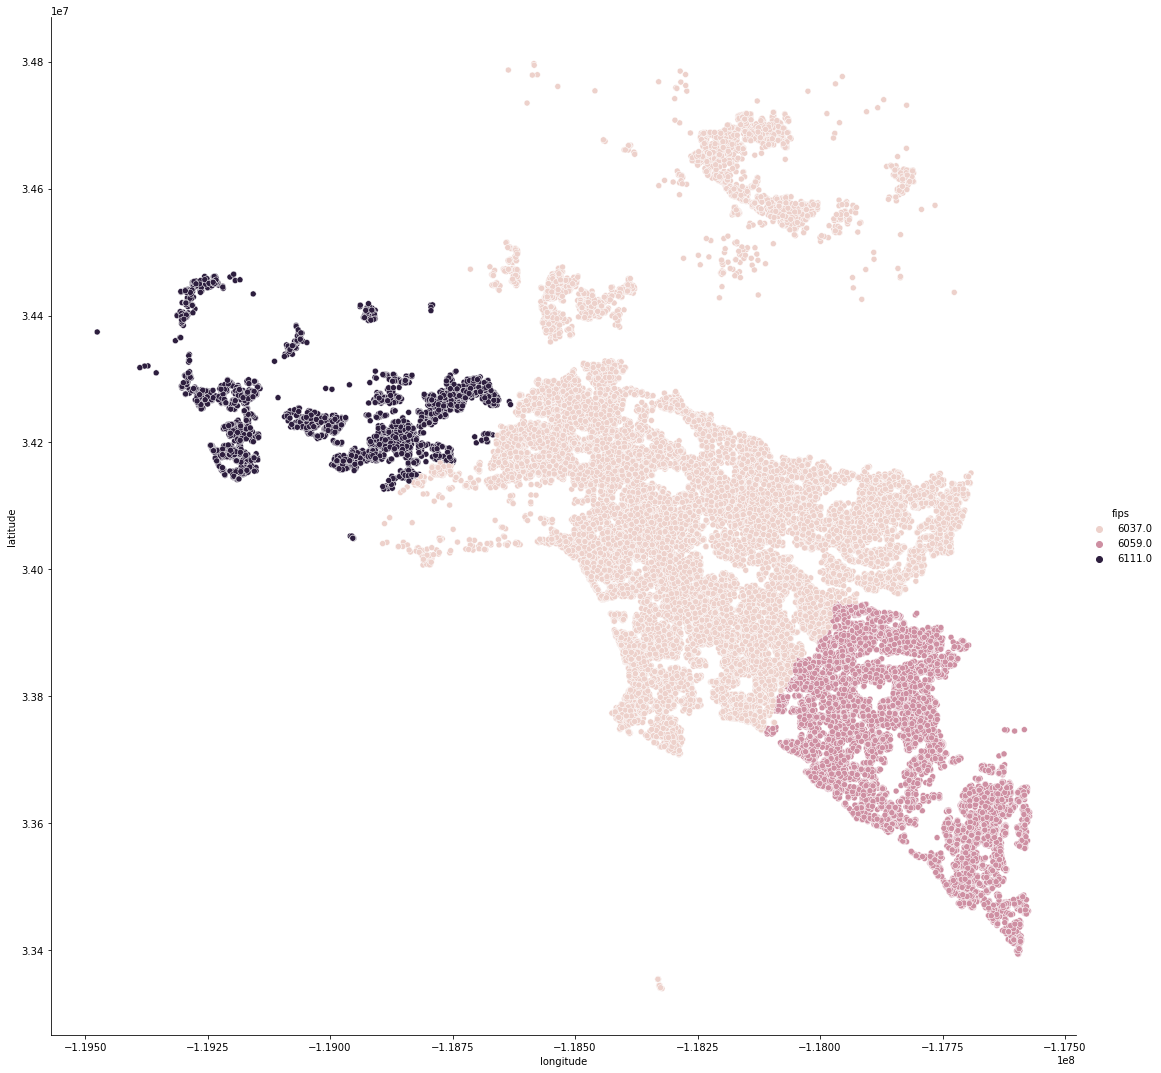

In [21]:
#plt.figure(figsize=(10,16))

sns.relplot(train.longitude, train.latitude, hue=train.fips, height=15)

# Takeaway
* Initially I thought logerror would vary noticeably depending on the latitude and longitude. But, the logerror seems to be uniform all throughout the landscape.
* Maybe if I bin logerror I can get a better visualization.

In [32]:
# Create a bunch of bins for logerror to see if it will help with visualzing logerror when plotted on top of longitude vs latitude
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])



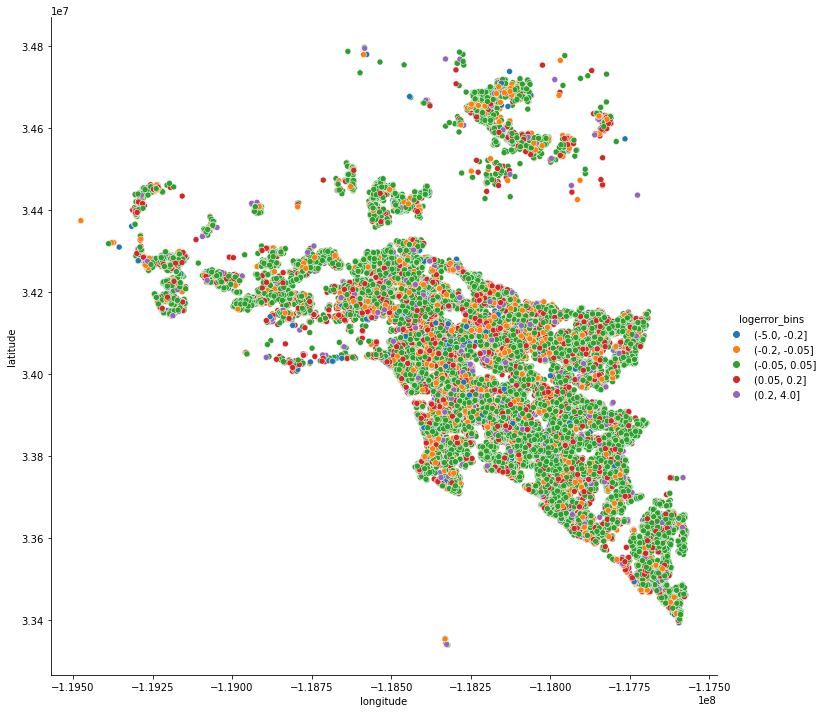

In [25]:
sns.relplot(train.longitude, train.latitude, hue=train.logerror_bins, height=10)

# Takeaways
* Binning the logerror made some of the observations stand out a little more, but I can't see any patterns as of now.
* Just call me Dora because I am about to...

### Explore!

### Target Variable: logerror
#### What will all our features look like plotted against the target (and everything else)?

In [ ]:
sns.pairplot(train, corner=True, hue='fips')

In [ ]:
plt.figure(figsize=(10, 18))

plt.subplot(221)
plt.scatter(train.bedroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bedrooms')

plt.subplot(222)
plt.scatter(train.bathroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bathrooms')

plt.subplot(223)
plt.scatter(train.calculatedfinishedsquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('home_area')

plt.subplot(224)
plt.scatter(train.lotsizesquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('land_area')

In [ ]:
train.info()

# Takeaways

* There doesn't seem to be any linear trend when plotting the independent variable against our target.
* There is a large variance in logerror among the lower end of the sepctrum across all variables.
* Small land area seems to have higher logerror.

### Scale the data

In [26]:
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37538 entries, 29637 to 5668
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   37538 non-null  float64 
 1   bedroomcnt                    37538 non-null  float64 
 2   calculatedfinishedsquarefeet  37538 non-null  float64 
 3   fips                          37538 non-null  float64 
 4   latitude                      37538 non-null  float64 
 5   longitude                     37538 non-null  float64 
 6   lotsizesquarefeet             37538 non-null  float64 
 7   regionidcity                  37538 non-null  float64 
 8   roomcnt                       37538 non-null  float64 
 9   yearbuilt                     37538 non-null  float64 
 10  structuretaxvaluedollarcnt    37538 non-null  float64 
 11  taxvaluedollarcnt             37538 non-null  float64 
 12  assessmentyear                37538 non-nul

(None, None, None)

In [35]:
# Create a scaler object using the MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler on the train dataset
# Use the select_dtypes to avoid an error when it tries to fit on the datetime datatype
scaler.fit(train.select_dtypes(include='float'))

# Use the scaler to transform the datasets
# Use the select_dtypes to avoid an error when it tries to transform on the datetime datatype
train_scaled = scaler.transform(train.select_dtypes(include='float'))
validate_scaled = scaler.transform(validate.select_dtypes(include='float'))
test_scaled = scaler.transform(test.select_dtypes(include='float'))

## Separate the target from the independent variables.

In [36]:
X_train = train.drop(columns=['logerror'])
X_validate = validate.drop(columns='logerror')
X_test = test.drop(columns='logerror')

In [37]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [38]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [41]:
y_train = train[['logerror']]
y_validate = validate[['logerror']]
y_test = test[['logerror']]

In [39]:
X_train_scaled.info(), X_validate_scaled.info(), X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37538 entries, 29637 to 5668
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   37538 non-null  float64
 1   bedroomcnt                    37538 non-null  float64
 2   calculatedfinishedsquarefeet  37538 non-null  float64
 3   fips                          37538 non-null  float64
 4   latitude                      37538 non-null  float64
 5   longitude                     37538 non-null  float64
 6   lotsizesquarefeet             37538 non-null  float64
 7   regionidcity                  37538 non-null  float64
 8   roomcnt                       37538 non-null  float64
 9   yearbuilt                     37538 non-null  float64
 10  structuretaxvaluedollarcnt    37538 non-null  float64
 11  taxvaluedollarcnt             37538 non-null  float64
 12  assessmentyear                37538 non-null  float64
 13

(None, None, None)

In [42]:
y_train.info(), y_validate.info(), y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37538 entries, 29637 to 5668
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   logerror  37538 non-null  float64
dtypes: float64(1)
memory usage: 586.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16160 entries, 68142 to 5498
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   logerror  16160 non-null  float64
dtypes: float64(1)
memory usage: 252.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13414 entries, 42377 to 1110
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   logerror  13414 non-null  float64
dtypes: float64(1)
memory usage: 209.6 KB


(None, None, None)

### Choose top five features

In [43]:
# Set the number of top features to present
k = 5

# Let's start with Select K Best
# Make the thing
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=5)

# fit the thing
kbest.fit(X_train, y_train)

# use the thing, 
# get_support() produces an array of booleans, so we can filter out the column names that matter the most
kbest_features = X_train.columns[kbest.get_support()].tolist()

print("KBest's 5 best features are", kbest_features)

KBest's 5 best features are ['bedroomcnt', 'calculatedfinishedsquarefeet', 'longitude', 'structure_dollar_per_sqft', 'structure_dollar_sqft_bin']


In [ ]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [ ]:
rfe_feature

# Set the baseline model

In [ ]:
# 1. Predict logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# Try using a linear regression model (OLS)

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

### Try using a LassoLars model

In [ ]:
# create the model object
lars = LassoLars(alpha=1.2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train[rfe_feature], y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train[rfe_feature])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate[rfe_feature])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
y_train.head(-10)

### Further exploration

#### What is the distribution of each of the  independent variables?

In [ ]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Does the mean logerror differ among the three counties?
LA_County = 6037

Orange_County = 6059

Ventura_County = 6111

In [ ]:
plt.title("Are Orange County Homes Consistently Being Overvalued?")
sns.barplot(x="fips", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

# Takeaway
* The mean logerror of Orange County seems to be significantly higher than the population average.
* The mean logerror of Ventura County seems slightly higher than the population average.
* The mean logerror of LA County seems slightly lower than the population average.

### I will run a statistical test to compare the mean logerror between counties.

In [ ]:
## Create a dataframe for each county.
#LA_county = train[train['fips']== 6037]
#Ventura_county = train[train['fips']== 6111]
#Orange_county = train[train['fips']== 6059]
#
## Create list of counties to make looping easier.
#county_list = [LA_county, Ventura_county, Orange_county]
#
## Verify shape of new dataframes.
#LA_county.shape, Ventura_county.shape, Orange_county.shape
#
## Create variables that hold the logerror values for each county.
#LA_logerror = LA_county['logerror']
#Ventura_logerror = Ventura_county['logerror']
#Orange_logerror = Orange_county['logerror']
#
#def create_features(df):
#    df['age'] = 2017 - df.yearbuilt
#    df['age_bin'] = pd.cut(df.age, 
#                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
#                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
#                                     .60, .666, .733, .8, .866, .933])
#
#    # create taxrate variable
#    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100
#
#    # create acres variable
#    df['acres'] = df.lotsizesquarefeet/43560
#
#    # bin acres
#    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
#                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
#
#    # square feet bin
#    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
#                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
#                            labels =  [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
#                       )
#
#    # dollar per square foot-structure
#    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
#
#
#    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
#                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
#                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
#                                            )
#
#
#    # dollar per square foot-land
#    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
#
#    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
#                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
#                                      )
#
#
#    # update datatypes of binned values to be float
#    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
#                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})
#
#
#    # ratio of bathrooms to bedrooms
#    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt
#
#    # 12447 is the ID for city of LA. 
#    # I confirmed through sampling and plotting, as well as looking up a few addresses.
#    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)
#
#    return df

In [ ]:
# Plot a histogram of logerror for each county.

for county in county_list:
    plt.figure(figsize=(10,8))
    plt.hist('logerror', bins=100, data=county)
    plt.show()

# Takeaways
* The logerror in all three counties are normally(ish) distributed. I will continue with an Independent t-test(setting equal_var to False if I must).

#### $H_0$: The mean logerror of Orange County is equal to the mean logerror of Ventura County.
#### $H_a$: The mean logerror of Orange County is greater than the mean logerror of Ventura County.

In [ ]:
# Check variances
LA_logerror.var(), Ventura_logerror.var(), Orange_logerror.var()

In [ ]:
# A stats Levene test - returns p value. small p-value means unequal variances
print(stats.levene(LA_logerror, Ventura_logerror))
print(stats.levene(LA_logerror, Orange_logerror))
print(stats.levene(Ventura_logerror, Orange_logerror))
# high p-value suggests that the populations have equal variances

# Takeaway
* There are equal variances between LA County logerror and both Ventura County and Orange County logerror.
* There is an unqual variance between Ventura County logerror and Orange County logerror.
* I will set the equal_var argument to False for the Ventura_vs_Orange Independent T-Test.

In [ ]:
# Set the level of significance (alpha):
alpha = 0.05

In [ ]:
# Use a Kruskal-Wallis test to test for equality in mean logerror between the three counties.
t, p = stats.kruskal(LA_logerror, Ventura_logerror, Orange_logerror)
print(f'p-value: {p}')
if p < alpha:
    print("We reject the null hypothesis that the mean logerror of the three counties are equal.")
else:
    pinrt("We fail to reject the null hypothesis.")

# Takeaway
* There is a difference between the three counties in mean logerror. I will create dummy variables for the counties and use them as a features in my model. 

In [ ]:
# Create dummy variables for the counties.
def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    return df_dummies

In [ ]:
train = get_counties(train)

In [ ]:
train

### From the pairplot I noticed that there was a greater variance in mean logerror for homes built after 1940. I will bin the train.yearbuilt into two bins 0: Houses built before 1940 and 1: Houses built after 1940.

### Takeaway
* It seems as if the variance in logerror increases for homes built after 1940.
* There seems to be 3 clusters. A middle cluster where most of the datapoints are situated, a top cluster, and a lower cluster.
* Maybe if create one bin from yearbuilt from yearbuilt.min() to about yearbuilt <= 1940 and one more bin for homes built after 1940 and compare the means between the two bins to see if there is a statistical difference.

In [ ]:
train['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)
X_train['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)
X_train_scaled['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)

In [ ]:
X_validate_scaled['age_bins'] = pd.cut(validate.yearbuilt, 10, labels=False)

In [ ]:
train.age_bins.value_counts()

In [ ]:
sns.relplot(train.age_bins, train.logerror, data=train, hue='fips')

In [ ]:
plt.title("Is Mean Logerror Higher in Homes Built After 1940")
sns.barplot(x="age_bins", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

# Takeaway
* Homes built before 1940(0) seem to have a lower mean logerror than the population.
* I will plot the distribution of the data and test for equal variance to determine which statistical test to run.

In [ ]:
older_homes_logerror = train[train.age_bins <= 4].logerror
newer_homes_logerror = train[train.age_bins >= 5].logerror

### $H_0$: There is no difference in mean logerror between older homes and newer homes.
### $H_a$: There is a difference in mean logerror between older homes and newer homes.

In [ ]:
# Check for equal variances.
# A stats Levene test - returns p value. small p-value means unequal variances.
t, p = stats.levene(older_homes_logerror, newer_homes_logerror)
# high p-value suggests that the populations have equal variances.

if p < alpha:
    print(f'p-value: {p}. There is unequal variance.')

In [ ]:
# Run a Independent T-Test to test for a difference in mean logerror between newer homes and older homes.
t, p = stats.ttest_ind(older_homes_logerror, newer_homes_logerror, equal_var=False)
if p < alpha:
    print(f'p-value: {p}. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

# Takeaway
* The mean logerror for newer homes seems to be greater than the mean logerror for older homes.

In [ ]:
X_train_scaled.info()

# Speaking of clusters...

In [ ]:
X = X_train_scaled[['latitude','longitude','age']]
X_v = X_validate_scaled[['latitude','longitude','age']]


In [ ]:
X, X_v

In [ ]:
# Create the KMeans object with three clusters.
kmeans = KMeans(n_clusters=3)

# Fit the KMeans object on the X values.
kmeans.fit(X)

# Use the KMeans object to predict the X_values and create a new column to store the values.
kmeans.predict(X)

In [ ]:
train.info()

In [ ]:
train['cluster'] = kmeans.predict(X)
X_train['cluster'] = kmeans.predict(X)
X_train_scaled['cluster'] = kmeans.predict(X)
X_validate_scaled['cluster'] = kmeans.predict(X_v)


In [ ]:
kmeans.cluster_centers_

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
X

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# Create the KMeans object with four clusters.
kmeans = KMeans(n_clusters=4)

# Fit the KMeans object on the X values.
kmeans.fit(X)

# Use the KMeans object to predict the X_values and create a new column to store the values.
kmeans.predict(X)

In [ ]:
X

In [ ]:
X_train['cluster'] = kmeans.predict(X)
X_train_scaled['cluster'] = kmeans.predict(X)

In [ ]:
kmeans.cluster_centers_

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='longitude', x='latitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Cluster Centers')

## Time to explore our clusters.

In [ ]:
plt.figure(figsize=(12,6))
#plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.cluster, alpha=.4)
plt.scatter(y=X_train.yearbuilt, x=X_train.longitude, c=X_train.cluster, alpha=.4)

In [ ]:
plt.scatter(y=y_train.logerror, x=X_train.yearbuilt, c=X_train.cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

In [ ]:
X_train.cluster.value_counts()

In [ ]:
X['cluster'] = kmeans.predict(X)

In [ ]:
train

In [ ]:
cluster_0 = train[train['cluster']==0]
cluster_1 = train[train['cluster']==1]
cluster_2 = train[train['cluster']==2]
cluster_3 = train[train['cluster']==3]

In [ ]:
# plot out income vs. spending with regard to the cluster and age
sns.relplot(data=train, x="yearbuilt", y="logerror", col="cluster", hue="latitude", col_wrap=2)

In [ ]:
train.info()

In [ ]:
X_train.info()

In [ ]:
X_train_scaled.info(), X_validate_scaled.info()

In [ ]:
X_train_scaled, X_validate_scaled

# *********************************************************************

# *********************************************************************

# *********************************************************************

In [ ]:
run_this_through_the_triplet_function = list(X_train_scaled.columns)

In [ ]:
# Get every possible combination of a set of three features
list_of_feature_combinations = list(combinations(run_this_through_the_triplet_function,3))

In [ ]:
# Fit this with clustering? I think that's the correct term. What is the length?
len(list_of_feature_combinations)

### I have a list of 680 combinations of features to cluster on. If I divide it into groups of 100 I will have 68 (6800/100) lists of features to work on at a time as to not overload the computer. I will print the [{inertia vs k}] graph for each group of ten and choose a k value based on the graphs. After I have my k value for each group I will assign that to the number of centroids for each group.

In [ ]:
X_train_scaled

In [ ]:
# I will convert all the tuples into lists and then to eventually Pandas dataframes.
# I'm not sure how long this will take. So I will test it on the first 10.
first_hundred = list_of_feature_combinations[:100]
second_hundred = list_of_feature_combinations[100:200]
third_hundred = list_of_feature_combinations[200:300]
fourth_hundred = list_of_feature_combinations[300:400]
fifth_hundred = list_of_feature_combinations[400:500]
sixth_hundred = list_of_feature_combinations[500:600]
last_eighty = list_of_feature_combinations[600:680]

In [ ]:
## THIS FUNCTION IS CURRENTLY UNDER CONSTRUCTION. PLEASE DO NOT ENTER... UNLESS YOU WANT TO PEFECT IT FOR ME.
# This function will take in a list of feature combinations which will be used for clustering. It will 
# return a list of the top 100 features:
#def get_rfe_ranking_for_bdoggs_clusters(hunnid):
#    # Create a list of the 100 features.
#    list_of_hundred_features = []
#    for combo in hunnid:
#        list_of_hundred_features.append(list(combo))
#    # Convert into dataframes.
#    list_of_dataframes = []
#    for combo in list_of_first_hundred_features:
#        list_of_dataframes.append(X_train[combo])
#    # plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
#    # 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
#    # *** ONLY RUN IF YOU HAVE TIME! ***
#    for combo in list_of_dataframes:
#        with plt.style.context('seaborn-whitegrid'):
#            plt.figure(figsize=(9, 6))
#            pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
#            plt.xticks(range(2, 12))
#            plt.xlabel('k')
#            plt.ylabel('inertia')
#            plt.title('Change in inertia as k increases')
#    
#    # This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.
#
#    # This cell takes ~ 30 seconds  to render with 100 clusters.
#
#    # set i to be the iteration count for number_of_centroids index
#    # set n to be the iteration count for list_of_dataframes index
#    i = 0
#    k = 0
#    list_of_cluster_predictions = []
#    for combo in list_of_dataframes: 
#        kmeans = KMeans(n_clusters = number_of_centroids[k])
#        kmeans.fit(list_of_dataframes[i])
#        X_train_scaled['cluster_' + str(i)] = kmeans.predict(combo)
#        list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
#        i += 1
#        k += 1
#    # Initialize the linear regression object!
#    lm = LinearRegression()
#
#    # Initialize the RFE object, setting the hyperparameters to be our linear regression object created above
#    # (as the algorithm to test the features on) and the number of features to return to be 5.
#    rfe = RFE(lm, n_features_to_select=16)
#
#    # Fit the RFE object to our data. This means create multiple linear regression models, find the one that 
#    # performs best, and identify the features that are used in that model. Those are the features we want.
#    # Transform our X dataframe to include only those 2 features. .transform() or do both of those steps together 
#    # with .fit_transform()
#
#    # Transforming data using RFE.
#    X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
#
#    #Fitting the data to model.
#    lm.fit(X_rfe,y_train)
#    
#    # Create boolean mask.
#    mask = rfe.support_
#    
#    # Store top 100 features into this variable.
#    rfe_features = X_train_scaled.loc[:, mask].columns.tolist()
#    
#    return rfe_features

# First Hundred

In [ ]:
# Create a list of the first 100 features.
list_of_hundred_features = []
for combo in first_hundred:
    list_of_hundred_features.append(list(combo))

In [ ]:
 list_of_hundred_features

In [ ]:
X_train_scaled

In [ ]:
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:
list_of_dataframes

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')
        

In [ ]:
# Create a list for the k values to pass into a for loop.
number_of_centroids = [5,3,4,4,4,5,4,4,5,4,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,3,4,4,3,3,4,6,4,5,4,6,5,4,4,4,5,4,5,4,6,6,4,5,4,4,4,4,5,7,4,5,5,4,5,5,4,4,6,4,3,4,3,5,4,4,4,3,3,4,4,3,4,3,4,4,4,3,3,3,3,3,3,3,4,4,3]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 0
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_train_scaled

# Second Hundred 

## This is the first half of the process:

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in second_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:

# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
# *** ONLY RUN IF YOU HAVE TIME! ***
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')



In [ ]:
number_of_centroids = [4,4,4,4,4,4,4,4,4,4,4,4,3,3,4,4,4,4,4,4,3,3,3,4,4,3,3,4,3,3,2,3,4,4,3,3,3,4,4,4,4,4,3,4,4,4,4,3,4,4,4,3,3,3,3,3,3,4,3,4,4,4,4,4,4,4,3,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,3,3,4,4,4,4,5,3]

len(number_of_centroids)

## This is the second half of the process. You can't proceed with this until you get the k-values from the first half of the process.

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.
# set i to be the iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 100
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_train_scaled

# Third Hundred

### First half of the process:

In [ ]:
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in third_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
# *** ONLY RUN IF YOU HAVE TIME! ***
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,4,5,4,4,4,4,4,3,5,4,4,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,4,3,4,3,3,4,4,4,4,4,4,4,4,4,4,4,3,3,4,3,4,3,4,4,4,4,4,4,4,3,3,4,3,4,3,4,4,3,3,4,4,3,3,4,4,3,4,3,3,3,4,4,4,4,4,4,4,4,4,4,4,3,3,4,3,3,4,2,3,3]

len(number_of_centroids)

### Second half of the process:

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.
# set i to be the iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 200
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1


In [ ]:
X_train_scaled

# Fourth Hundred

### First half of process:

In [ ]:
# Running this cell took 11 minutes and 55.51 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in fourth_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
# *** ONLY RUN IF YOU HAVE TIME! ***
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,4,3,3,3,4,4,3,3,3,3,3,4,4,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,4,3,4,3,3,4,3,2,2,4,3,3,4,4,4,3,3,4,5,3,4,3,3,3,4,3,3,4,4,3,3,3,3,3,4,4,3,4,4,3,3,4,4,4,3,3,4,3,3,3,4,4,3,3,4,4,4,3,3,4,4,3,4,4,4]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.
# set i to be the iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 300
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1


In [ ]:
X_train_scaled

# Fifth Hundred

### First half of process:

In [ ]:
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in fifth_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
# *** ONLY RUN IF YOU HAVE TIME! ***
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,4,4,4,4,4,4,3,4,4,3,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,4,4,3,3,3,3,3,4,2,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3,2,3,2,3,4,4,3,3,4,4,3,3,4,4,4,3,3,4,4,4,4,4,3,4,3,3,4,3,4,4,4,3,3,4,4,3,4,4,3,4,3,3]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.
# set i to be the iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 400
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_train_scaled

# Last 60

### First half of process:

In [ ]:
# Running this cell took 11 minutes and 55.51 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in last_sixty:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_train_scaled[combo])

In [ ]:

# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# 100 dataframes will take ~ 9 minutes and 10 seconds to render  & CPU % up to 675
# *** ONLY RUN IF YOU HAVE TIME! ***
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,4,3,3,3,4,4,4,3,4,3,4,3,4,4,3,4,4,4,3,3,3,4,3,4,3,4,3,4,4,3,4,4,4,3,4,4,4,4,4,4,3,3,3,4,3,4,3,3,3,3,4,3,4,4,3,3,3,3,4]

len(number_of_centroids)

### Second half of process: 

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.
# set i to be the iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 500
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_train_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1
    


In [ ]:
# FINALLY FINISHED!!!  PART 2!... Part 6!
X_train_scaled

# Now do for validate
# First Hundred

In [ ]:
# Running this cell took 11 minutes and 55.51 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in first_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,3,5,4,3,4,4,4,3,3,4,3,5,3,3,5,3,4,4,3,4,4,4,4,4,5,3,3,3,4,4,4,3,3,4,4,3,5,4,2,4,3,4,5,3,3,4,4,5,3,3,4,3,3,4,4,4,3,5,3,2,3,4,4,4,4,4,5,3,3,2,2,4,3,3,4,3,3,4,4,3,3,5,3,4,4,4,4,5,3,4,4,4,5,3,4,4,5,3,3]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 0
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

# Second Hundred

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in second_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [5,3,5,3,3,3,3,3,4,4,4,4,3,4,4,3,5,3,4,3,3,4,4,3,3,3,3,4,5,4,3,3,5,3,4,4,3,3,3,4,3,3,4,3,3,4,4,3,3,4,3,4,4,4,4,4,4,4,5,3,3,4,4,4,4,4,5,3,4,4,4,4,4,5,3,2,4,4,4,5,3,3,2,3,3,3,4,4,5,3,3,4,3,4,3,3,3,3,3,4]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 100
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_validate_scaled

# Third Hundred

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in third_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,3,3,3,3,3,5,4,2,3,4,3,4,4,4,4,3,4,3,4,4,3,3,4,4,4,4,5,3,3,4,3,2,3,3,3,4,3,3,3,3,3,3,3,4,3,4,3,4,4,4,5,3,3,3,3,4,4,3,3,3,4,4,3,3,3,4,3,3,5,3,5,3,3,3,4,4,4,4,3,3,4,3,4,4,3,3,4,3,3,3,4,4,4,4,4,4,3,3,3]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 200
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_validate_scaled

# Fourth Hundred

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in fourth_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [3,3,4,4,4,4,4,3,3,4,3,4,4,4,4,4,4,4,4,3,3,3,3,4,4,3,3,3,4,4,3,3,5,4,3,5,4,4,4,3,3,4,3,2,2,3,3,2,4,3,4,3,3,4,4,3,3,5,3,3,5,4,4,5,5,5,3,3,3,3,3,4,4,3,3,3,4,4,4,3,3,4,3,4,3,3,3,4,3,3,4,3,3,3,3,4,3,3,4,4]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 300
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

# Fifth Hundred

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in fifth_hundred:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [4,4,5,3,4,4,4,4,4,4,4,3,3,3,3,3,3,5,3,4,4,4,4,5,3,4,4,3,5,3,3,4,4,3,4,5,3,5,3,3,3,3,3,3,3,3,5,3,4,4,4,4,4,5,3,3,4,2,3,4,3,2,3,3,5,3,3,2,5,3,3,5,3,5,3,2,3,3,3,3,3,5,3,5,3,3,4,5,3,3,3,5,5,3,3,3,5,3,3,5]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 400
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

# Last 60

In [ ]:
# Running this cell took 10 minutes and 03.95 seconds. CPU % ~ 730 for this cell.
# Create a list of the 100 features.
list_of_hundred_features = []
for combo in last_sixty:
    list_of_hundred_features.append(list(combo))
# Convert into dataframes.
list_of_dataframes = []
for combo in list_of_hundred_features:
    list_of_dataframes.append(X_validate_scaled[combo])

In [ ]:
# plot delta(inertia) graphs for each group of clusters. Takes ~ 42.37 seconds to run on 10 clusters. Might want to ask Ryan if it's possible to cache the information that is returned.
# I'm guessing 100 dataframes will take ten times as long? Let's see: 9 minutes and 10 seconds  & CPU % up to 675
for combo in list_of_dataframes:
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(combo).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [ ]:
number_of_centroids = [3,5,3,3,4,4,4,4,5,3,4,4,4,5,3,4,4,5,3,4,5,3,5,3,3,3,3,3,4,3,3,3,5,3,4,4,3,5,3,3,4,4,5,3,4,5,3,5,3,3,3,5,3,5,3,3,5,3,3,3]

len(number_of_centroids)

In [ ]:
# This cell will iterate through the list of dataframes and fit the kmeans with the specified number of centroids extracted from the [{inertia vs k}] graphs above.

# This cell takes ~ 30 seconds  to render with 100 clusters.

# set i to be thea iteration count for number_of_centroids index
# set n to be the iteration count for list_of_dataframes index
i = 0
k = 0
s = 500
list_of_cluster_predictions = []
for combo in list_of_dataframes: 
    kmeans = KMeans(n_clusters = number_of_centroids[k])
    kmeans.fit(list_of_dataframes[i])
    X_validate_scaled['cluster_' + str(s)] = kmeans.predict(combo)
    list_of_cluster_predictions.append(kmeans.predict(list_of_dataframes[i]))
    i += 1
    k += 1
    s += 1

In [ ]:
X_train_scaled, X_validate_scaled

In [ ]:
y_train, y_validate

# Time to fit the model on my data to get the top performing features!

In [ ]:
## Running this cell with this much data processing takes about 3 minutes.
# Initialize the linear regression object!
lm = LinearRegression()
# Initialize the RFE object, setting the hyperparameters to be our linear regression object created above
# (as the algorithm to test the features on) and the number of features to return to be 5.
rfe = RFE(lm, n_features_to_select=100)
# Fit the RFE object to our data. This means create multiple linear regression models, find the one that 
# performs best, and identify the features that are used in that model. Those are the features we want.
# Transform our X dataframe to include only those 2 features. .transform() or do both of those steps together 
# with .fit_transform()
# Transforming data using RFE.
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
#Fitting the model onto new clusters.
lm.fit(X_rfe,y_train)

# Create boolean mask.
mask = rfe.support_

# Store top 100 features into this variable.
rfe_features = X_train_scaled.loc[:, mask].columns.tolist()

In [ ]:
rfe_features

In [ ]:
train

In [ ]:
# Reset y_train and y_validate
y_train['logerror'] = train.logerror

In [ ]:
columns_to_drop = ['logerror_pred_mean','logerror_pred_median','logerror_pred_lm','logerror_pred_lm2']
y_train.drop(columns=columns_to_drop, inplace=True)

In [ ]:
y_train

In [ ]:
f_selector = SelectKBest(f_regression, k=10)

f_selector.fit(X_train_scaled, y_train)

X_reduced = f_selector.transform(X_train_scaled)

print(X_train_scaled.shape)
print(X_reduced.shape)

X_reduced2 = SelectKBest(f_regression, k=2).fit_transform(X_train_scaled, y_train)
print(X_reduced2.shape)

f_support = f_selector.get_support()

f_feature = X_train_scaled.loc[:,f_support].columns.tolist()

# you could also get the list this way (among many others)
# f_feature = [X_train_scaled.columns.values[i] for i in range(len(feature_mask)) if feature_mask[i]==True]

print(str(len(f_feature)), 'selected features')
best_feats = f_feature[3:8]

In [ ]:
# Choose 5 of the best clusters. If this is over fit use less.
best_feats

In [ ]:
X_train_scaled[best_feats]

# Now use the top five clusters on my OLS model.

In [ ]:
y_train

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled[best_feats], y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_scaled[best_feats])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_scaled[best_feats])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS Model using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

# Moment of truth!  Part 2! I mean Part 3! Part 4 is a charm?

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(X_train_scaled[first_fifty], y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[first_fifty])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate_scaled['logerror_pred_lm'] = lm.predict(X_validate_scaled[first_fifty])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
y_train.info(), y_validate.info(), X_train_scaled.info(), X_validate_scaled.info()